In [1]:
import sys
sys.path.append("../")
import importlib
import train_loops
import run
import torch
from utils import utils
import wandb
import logging
import os 
from pathlib import Path
from configs.config_o2mnist import config
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sample train data


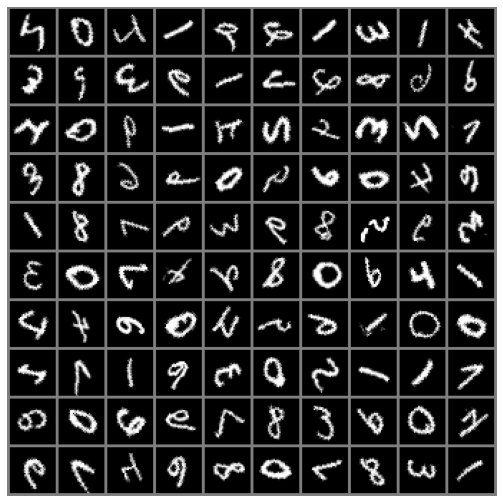

In [2]:
importlib.reload(utils)
# get datasets specified by config.data
dset, loader, dset_test, loader_test = run.get_datasets_from_config(config)
data_imgs, data_imgs_test = dset.tensors[0], dset_test.tensors[0]
print("sample train data")
f, axs = utils.plot_sample_data(loader)
f

In [3]:
config.model.encoder.n_channels=dset[0][0].shape[0]  # image channels
model = run.build_model_from_config(config)
print(model.model_details())

Encoder type <class 'models.encoders_o2.e2scnn.E2SFCNN'>
Decoder type <class 'models.decoders.cnn_decoder.CnnDecoder'>
Bottleneck dims 64
Loss func: bce, beta=0.01 loss aligns output: True 
Parameter counts: 
 encoder 169,504
 decoder 317,185
 total   486,689


## Load pretrained model
**Important** change the below variable `dir_home` to point at the home directory of o2vae. 

In [5]:
dir_home = "/pasteur/u/jmhb/o2vae"

f_pretrained_model = os.path.join(dir_home, "wandb/pretrained_models/model_o2_mnist.pt")
print(f"Loading pretrained model {f_pretrained_model}")
model_checkpoint = torch.load(f_pretrained_model)
missing_keys, unexpected_keys = model.load_state_dict(model_checkpoint['model_state_dict'], strict=False)
assert all(['_basisexpansion' in k for k in missing_keys])
assert len(unexpected_keys) == 0 

Loading pretrained model /pasteur/u/jmhb/o2vae/wandb/pretrained_models/model_o2_mnist.pt


## Sample reconstructions 

Left: reconstructions.
Right: reconstructions where output is re-algined


/pasteur/u/jmhb/miniconda3/envs/o2vae/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/pasteur/u/jmhb/miniconda3/envs/o2vae/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


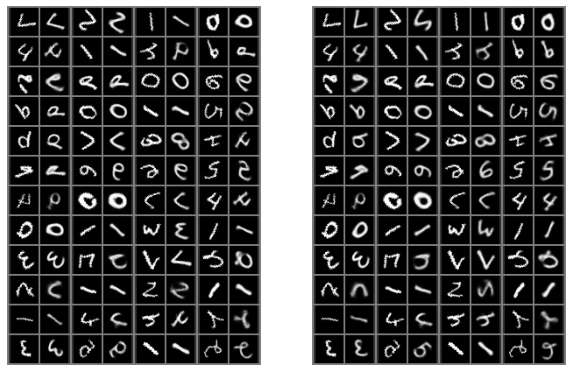

In [60]:
from utils import eval_utils
import matplotlib.pyplot as plt
importlib.reload(eval_utils)
model.eval().to(device) 

x,y = next(iter(loader_test))
reconstruct_grid = eval_utils.reconstruction_grid(model, x, align=False)
reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x, align=True)
f,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(reconstruct_grid)
axs[1].imshow(reconstruct_grid_aligned)
print("Left: reconstructions.")
print("Right: reconstructions where output is re-algined")
axs[0].set_axis_off();  axs[1].set_axis_off()

## Verify orientation invariance

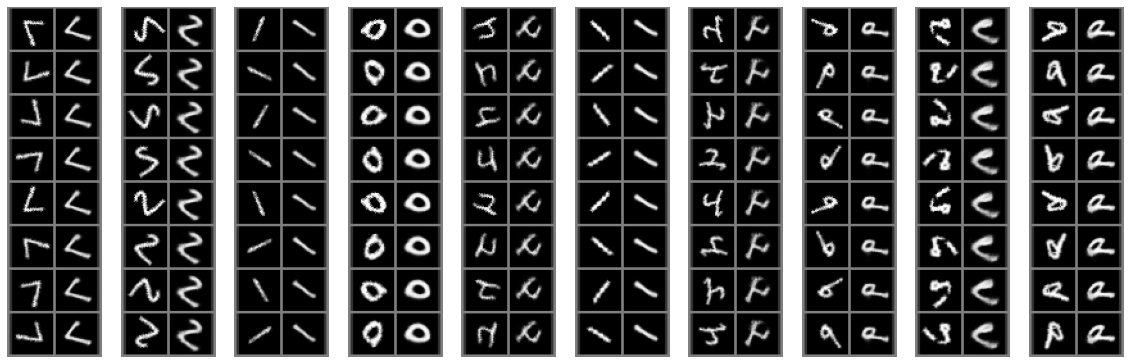

In [20]:
importlib.reload(eval_utils)
f, axs = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    xs = eval_utils.rotated_flipped_xs(x[[i]], 90)[:,0]
    grid = eval_utils.reconstruction_grid(model, xs, align=False, ncol=2)
    axs[i].imshow(grid)
    axs[i].set_axis_off()

## Extract features

In [7]:
device='cuda'
embeddings, y_true = utils.get_model_embeddings_from_loader(model, loader, return_labels=True)
embeddings_test, y_true_test = utils.get_model_embeddings_from_loader(model, loader_test, return_labels=True)

100%|██████████| 40/40 [00:05<00:00,  7.27it/s]


## k-nearest neighbour image samples

In [8]:
# get distance from each point in test to each point in train
first_n=10000 # only sample the first 10k points bc otherwise computation takes too long
dist_train = torch.cdist(embeddings[:first_n].to(device), embeddings[:first_n].to(device), p=2).cpu()
dist_argsort = torch.argsort(dist_train.to(device), dim=1).cpu()

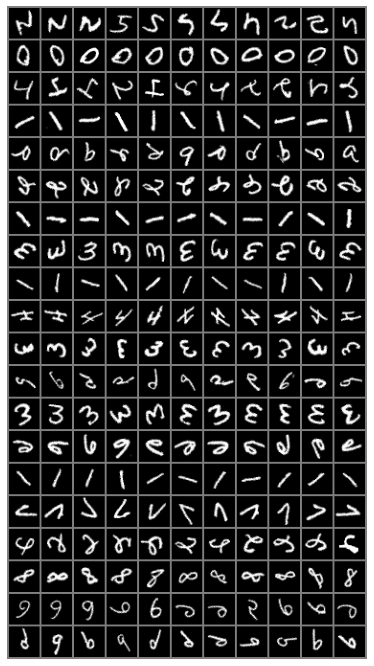

In [9]:
# sample some test_idxs (default is the first 20), then sample the k-nearest neighbours
k=10
test_idxs = torch.arange(20)

this_dist_argsort = dist_argsort[test_idxs,:k+1]
imgs = data_imgs[this_dist_argsort.flatten()]
grid = make_grid(imgs, k+1, pad_value=0.5).moveaxis(0,2)
f,axs = plt.subplots(figsize=(12,12))
axs.imshow(grid)
axs.set_axis_off()


## UMAP

In [10]:
import umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(embeddings)


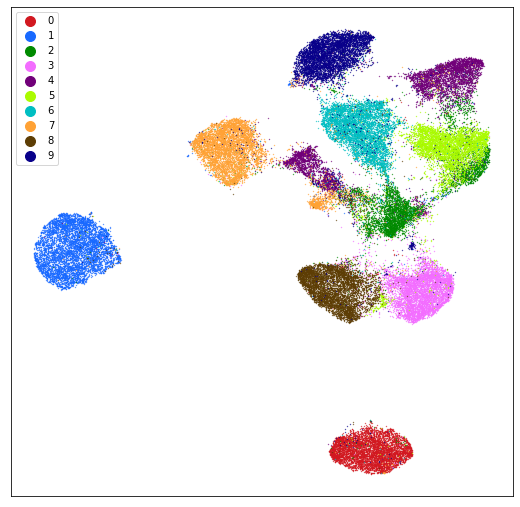

In [12]:
from analysis import plotting_utils
f,axs = plotting_utils.plot_embedding_space_w_labels(umap_embedding, y_true)
f

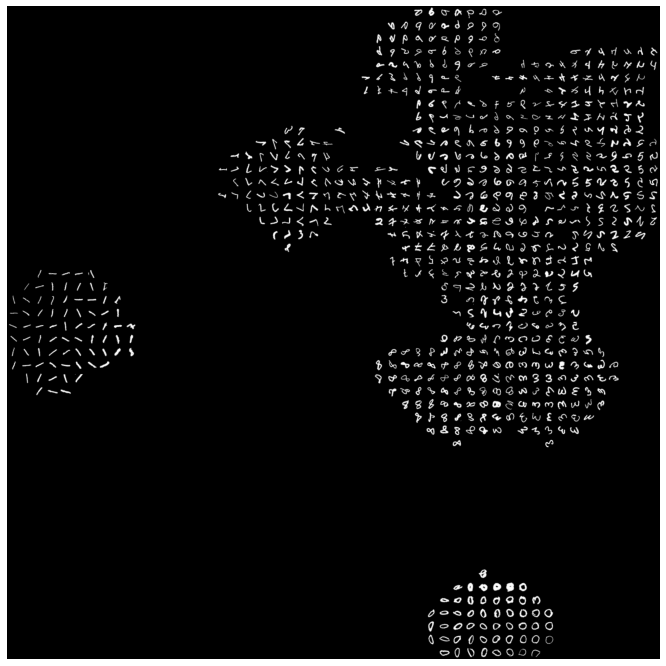

In [13]:
# this requires access to an array of the original images
images = loader.dataset.tensors[0]
images.shape, umap_embedding.shape
grid, idxs = plotting_utils.get_embedding_space_embedded_images(umap_embedding, images, n_ximgs=50, n_yimgs=50)
f, axs = plt.subplots(figsize=(12,12))
axs.set_axis_off()
axs.imshow(grid, cmap='gray')

## Clustering 


In [14]:
from utils import cluster_utils
importlib.reload(cluster_utils)

n_clusters=10
(labels_gmm, labels_kmeans), ((pca, cls_gmm), cls_kmeans), (centers_gmm, centers_kmeans), (scores_gmm, scores_kmeans) \
    = cluster_utils.do_clusterering(embeddings, n_clusters=n_clusters)

In [15]:
## choose whether to use the gmm or kmeans clusters
method = "gmm" # 'gmm' or 'kmeans'
if method=='gmm':
    labels, centers, scores = labels_gmm, centers_gmm, scores_gmm
elif method=='gmm':
    labels, centers, scores = labels_kmeans, centers_kmeans, scores_kmeans
else:
    raise ValueError()

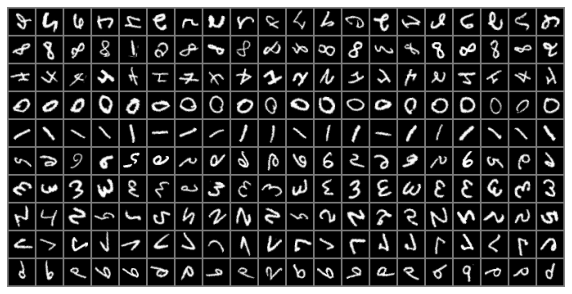

In [16]:
import matplotlib
### sample images from the cluster - 
# param `cluster_sampling_method`. 
    # If `none` then random sample
    # If `uniform` then using `score` (likelihood object is in its cluster), sample uniformly 
    #      from high score (left) to low score (right)
    # If `top` sample high `score`
    # If `bottom` sample low `score`
    # if `std`, then remove samples that have the lowest `score`, where the threshold is 
    #     found by measruing std deviation of score, and thresholding with param stds_filt (default 1)
# param n_examples: number of samples per cluster

cluster_sampling_method='std'
n_examples=20
grid, counts = cluster_utils.make_sample_grid_for_clustering(labels, data_imgs, scores, n_examples=n_examples, stds_filt=1,
                                            method=cluster_sampling_method, paper_figure_grid=0, verbose=0)
f,axs = plt.subplots(figsize=(10,10))
axs.imshow(grid)
axs.set_axis_off();

In [17]:
## at epoch 30
from utils import cluster_utils
importlib.reload(cluster_utils)
print("Purity score for clustering with k=10")
print(f"GMM:    {cluster_utils.purity_score(y_true, labels_gmm):.3f}")
print(f"Kmeans: {cluster_utils.purity_score(y_true, labels_kmeans):.3f}")

Purity score for clustering with k=10
GMM:    0.818
Kmeans: 0.737
